# Airbnb data analysis 
### by Lei Wang
### 04-04-2019

## Data input and processing 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# input list files
listing = pd.read_csv("C:/Users/Lenovo/Desktop/listings.csv")
listing_detailed = pd.read_csv("C:/Users/Lenovo/Desktop/listings_detailed.csv")
# input reviews file
reviews = pd.read_csv("C:/Users/Lenovo/Desktop/reviews.csv")
# input calendar file
calendar = pd.read_csv("C:/Users/Lenovo/Desktop/calendar.csv")

In [3]:
# Feature selection
listing_detailed = pd.DataFrame(listing_detailed[['id', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed', 'property_type', 'room_type', 'minimum_nights', 'availability_365', 'number_of_reviews', 'last_review', 'review_scores_rating', 'cancellation_policy', 'reviews_per_month', 'calculated_host_listings_count']])
listing_detailed = listing_detailed.join(listing['price'])

In [4]:
# correct date type
listing_detailed['last_review'] = pd.to_datetime(listing_detailed['last_review'])
listing_detailed['last_review_days'] = (pd.to_datetime('2019-03-06') - listing_detailed['last_review']).dt.days
listing_detailed['host_response_rate'] = listing_detailed['host_response_rate'].str.rstrip('%').astype('float') / 100.0

### Summary statistics for continuous variables

In [5]:
listing_detailed.describe()

,id,host_response_rate,minimum_nights,availability_365,number_of_reviews,review_scores_rating,reviews_per_month,calculated_host_listings_count,price,last_review_days
count,7.151000e+03,6426.000000,7.151000e+03,7151.000000,7151.000000,5730.000000,5774.000000,7151.000000,7151.000000,5774.000000
mean,1.666813e+07,0.964147,1.400030e+04,148.552510,43.529157,95.546946,1.861178,16.407076,213.654034,148.609629
std,1.047778e+07,0.116254,1.182542e+06,128.463382,72.519229,6.935152,1.994601,40.628555,313.282220,267.631043
min,9.580000e+02,0.000000,1.000000e+00,0.000000,0.000000,20.000000,0.010000,1.000000,0.000000,1.000000
25%,6.867674e+06,1.000000,2.000000e+00,26.000000,1.000000,94.000000,0.340000,1.000000,100.000000,16.000000
50%,1.803718e+07,1.000000,4.000000e+00,119.000000,11.000000,98.000000,1.090000,2.000000,150.000000,42.000000
75%,2.568141e+07,1.000000,3.000000e+01,271.000000,54.000000,100.000000,2.800000,6.000000,235.000000,165.750000
max,3.284519e+07,1.000000,1.000000e+08,365.000000,677.000000,100.000000,12.800000,204.000000,10000.000000,3075.000000


### Correlation matrix for continuous variables

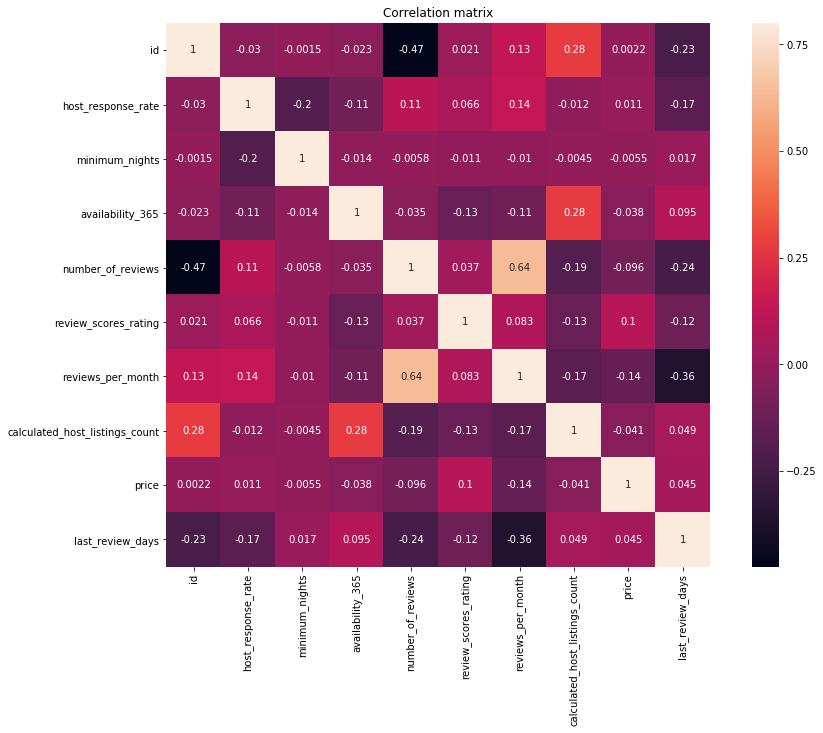

In [6]:
#correlation matrix
corrmat = listing_detailed.corr()
plt.figure(figsize=(15,10))
plt.title('Correlation matrix')
#fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, annot=True, vmax=.8, square=True);


## Part 1 Price analysis

### Price distribution over neighbourhood

In [7]:
import geopandas as gpd
df = gpd.read_file('C:/Users/Lenovo/Desktop/neighbourhoods.geojson')
geometry = df[['neighbourhood', 'geometry']]

In [8]:
listing_by_neighbourhood = pd.DataFrame(listing_detailed.groupby('neighbourhood_cleansed')['id'].count())
price_by_neighbourhood = pd.DataFrame(listing_detailed.groupby('neighbourhood_cleansed')['price'].mean())


Text(0.5,1,'Average price of neighbourhood')

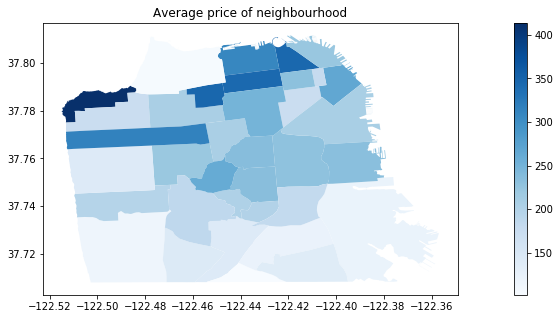

In [9]:
geometryn = pd.merge(geometry, price_by_neighbourhood, left_on='neighbourhood', right_on='neighbourhood_cleansed')
ax=geometryn.plot(column='price', cmap='Blues', legend=True, figsize=(20,5))
ax.set_title('Average price of neighbourhood')

Text(0.5,1,'Average number of listings of neighbourhood')

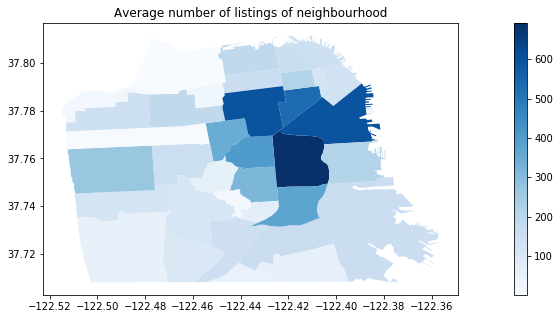

In [10]:
geometrym = pd.merge(geometry, listing_by_neighbourhood, left_on='neighbourhood', right_on='neighbourhood_cleansed')
ax=geometrym.plot(column='id', cmap='Blues', legend=True, figsize=(20,5))
ax.set_title('Average number of listings of neighbourhood')

### Room type vs price

In [11]:
pd.DataFrame(listing_detailed.room_type.value_counts())

,room_type
Entire home/apt,4366
Private room,2606
Shared room,179


In [12]:
pd.DataFrame(listing_detailed.groupby('room_type')['price'].mean())

,price
room_type,
Entire home/apt,267.959230
Private room,132.026094
Shared room,77.486034


### Feature selection by regression with Lasso

In [13]:
from sklearn import datasets, linear_model
listing_nonull = listing_detailed.dropna()
listing_Y = pd.DataFrame(listing_nonull['price'])
listing_X = pd.DataFrame(listing_nonull[['host_response_rate', 'minimum_nights', 'number_of_reviews', 'availability_365', 'review_scores_rating', 'calculated_host_listings_count','last_review_days']])
dummy = pd.get_dummies(data=listing_nonull[['host_response_time', 'host_is_superhost', 'host_identity_verified','neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']], drop_first=True)
listing_X = listing_X.join(dummy)

In [14]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

lasso = Lasso()
lasso.fit(listing_X, listing_Y)
train_score=lasso.score(listing_X, listing_Y)
coeff_used = np.sum(lasso.coef_!=0)
print( "training score:", train_score )
print ("number of features used: ", coeff_used)

training score: 0.1334423597908282
number of features used:  26


In [15]:
coefficients = pd.DataFrame(lasso.coef_, columns=['coefficients'])
zero_ornot = pd.DataFrame(lasso.coef_!=0, columns=['YN'])
variables = pd.DataFrame(listing_X.columns, columns=['variables'])
cof_table = zero_ornot.join(variables).join(coefficients)
cof_table = cof_table[cof_table['YN']==True]

In [16]:
cof_table

,YN,variables,coefficients
1,True,minimum_nights,-1.145495
2,True,number_of_reviews,-0.319784
3,True,availability_365,0.003762
4,True,review_scores_rating,2.416565
5,True,calculated_host_listings_count,-0.618257
6,True,last_review_days,0.045350
9,True,host_response_time_within an hour,22.760510
11,True,host_identity_verified_t,27.850867
12,True,neighbourhood_cleansed_Bernal Heights,-30.904802
18,True,neighbourhood_cleansed_Excelsior,-46.239757


## Part 2 Review analysis

### Review regression with Lasso

In [19]:
Y = pd.DataFrame(listing_nonull['review_scores_rating'])
X = pd.DataFrame(listing_nonull[['host_response_rate', 'minimum_nights', 'number_of_reviews', 'availability_365', 'price', 'calculated_host_listings_count','last_review_days']])
dummy = pd.get_dummies(data=listing_nonull[['host_response_time', 'host_is_superhost', 'host_identity_verified','neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']], drop_first=True)
X = X.join(dummy)
lasso = Lasso()
lasso.fit(X, Y)
train_score=lasso.score(X, Y)
coeff_used = np.sum(lasso.coef_!=0)
print( "training score:", train_score )
print ("number of features used: ", coeff_used)

training score: 0.049575761580525235
number of features used:  6


In [20]:
coefficients = pd.DataFrame(lasso.coef_, columns=['coefficients'])
zero_ornot = pd.DataFrame(lasso.coef_!=0, columns=['YN'])
variables = pd.DataFrame(X.columns, columns=['variables'])
cof_table = zero_ornot.join(variables).join(coefficients)
cof_table = cof_table[cof_table['YN']==True]
cof_table

,YN,variables,coefficients
1,True,minimum_nights,-0.019952
2,True,number_of_reviews,0.001118
3,True,availability_365,-0.004507
4,True,price,0.002275
5,True,calculated_host_listings_count,-0.022260
6,True,last_review_days,-0.002242


### Word cloud

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [22]:
# select listing id with review scores rating lower than 90
low_review_id = pd.DataFrame(listing_detailed[(listing_detailed.review_scores_rating<=90) & (listing_detailed.review_scores_rating>=0)]['id'])

In [23]:
# select comments from id with lower rating
low_reviews = pd.merge(low_review_id, reviews, left_on = 'id', right_on = 'listing_id')
low_reviews = low_reviews[['listing_id', 'comments']]
low_reviews['comments'] = low_reviews['comments'].astype(str)

In [24]:
# input a negative words list
negative= pd.read_csv("C:/Users/Lenovo/Desktop/negative.csv")
negative_list = negative['abnormal'].tolist()

In [25]:
#import nltk
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [26]:
from nltk.tokenize import sent_tokenize, word_tokenize
text = " ".join(review for review in low_reviews['comments'])
word_token = word_tokenize(text)

In [27]:
negative_words =[]
for i in word_token:
    if i in negative_list:
        negative_words.append(i)

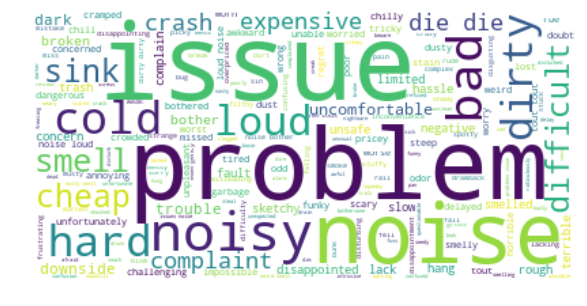

In [29]:
negative_text = ' '.join(negative_words)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color="white").generate(negative_text)
plt.figure( figsize=(25,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Availability analysis

### Average availability over neighbourhood

Text(0.5,1,'Average availability of neighbourhood')

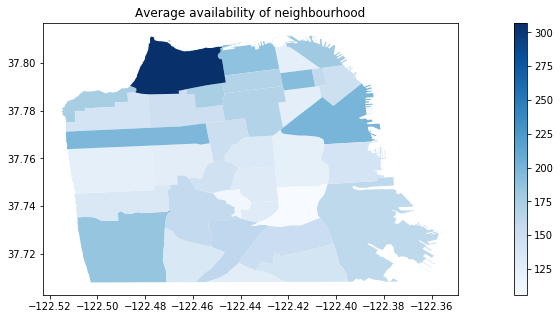

In [30]:
availability_by_neighbourhood = pd.DataFrame(listing_detailed.groupby('neighbourhood_cleansed')['availability_365'].mean())
geometryo = pd.merge(geometry, availability_by_neighbourhood, left_on='neighbourhood', right_on='neighbourhood_cleansed')
ax=geometryo.plot(column='availability_365', cmap='Blues', legend=True, figsize=(20,5))
ax.set_title('Average availability of neighbourhood')

### Unavailability over time

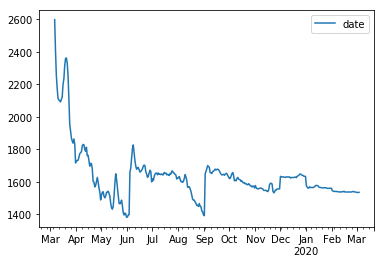

In [31]:
calendar['date'] = pd.to_datetime(calendar['date'], format='%m/%d/%Y')
unavailabe = calendar[calendar['available']=='f']
unavailable_by_date = pd.DataFrame(unavailabe['date'].value_counts()).sort_index()
unavailable_by_date.plot()

### Rent term vs Availability

In [32]:
listing_detailed['minimum_nights_level'] = np.where(listing_detailed['minimum_nights'] >=30, 'long term', 'short term')

In [33]:
listing_detailed.minimum_nights_level.value_counts()

short term    4096
long term     3055
Name: minimum_nights_level, dtype: int64

In [34]:
pd.DataFrame(listing_detailed.groupby('minimum_nights_level')['availability_365'].mean())

,availability_365
minimum_nights_level,
long term,214.079869
short term,99.678955
